### Library / Config

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import polars as pl
import os
import gc
from collections import defaultdict
from typing import *
from typing_extensions import Literal
import matplotlib.pyplot as plt
import pdb
import pickle
from tqdm import tqdm
from pathlib import Path
import itertools

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import lightgbm as lgb

from src.data_process import load_train_df, load_labels, TrainIterator
from src.utils import reduce_memory, seed_everything, TimeUtil, Logger,  vis_feat_imp
from src.metrics import get_score_and_th
from src.gbdt.feature_engineering import execute_feature_engineering
from src.gbdt.model import all_level_group_train
from src.gbdt.feature_selection import select_feature

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_colwidth', 1000)

In [2]:
class CFG:
    exp = '090'
    run_type: Literal['all', 'half', 'dev', 'debug'] = 'all'
    
    input_path = Path('../data/input')
    output_path = Path(f'../data/output/exp_{exp}')
    output_path.mkdir(parents=True, exist_ok=True)
    
    fold = 5
    seed = 77
    model_type: Literal['lgb', 'xgb', 'cat'] = 'xgb'
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric':'logloss',
        'tree_method': 'hist', # gpu_hist
        'learning_rate': 0.01,
        'max_depth': 4,
        'max_leaves': 16,
        'subsample': 0.80,
        'colsample_bytree': 0.40,
        'seed': seed
    }
    # 閾値最適化
    all_opt = True
    each_opt = False

In [3]:
seed_everything(CFG.seed)
logger = Logger(CFG.output_path, CFG.exp, CFG)

### Feature Engineering

In [4]:
# load
train_df = load_train_df(CFG.run_type, CFG.input_path / 'train.parquet')
train_labels = load_labels(CFG.input_path / 'train_labels.csv')
iter_train = TrainIterator(train_df)

In [5]:
# execute fe
all_df = execute_feature_engineering(iter_train)

  0%|          | 0/900 [00:00<?, ?it/s]

Level Group=0, (300, 2619), Feature num after reduction: 372
Level Group=1, (300, 8166), Feature num after reduction: 1201
Level Group=2, (300, 16734), Feature num after reduction: 2502


In [6]:
for i in range(3):
    print(all_df[i].shape)

(300, 2619)
(300, 8166)
(300, 16734)


### Train GBDT

In [7]:
oof_df, models_all = all_level_group_train(
    CFG,
    all_df,
    train_labels,
    use_feat_dict = None,
    use_prev_pred = True,
    save_model = True,
    train_type = 'non_fs'
)

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-logloss:0.68728	valid-logloss:0.68765
[100]	train-logloss:0.34483	valid-logloss:0.39372
[200]	train-logloss:0.22736	valid-logloss:0.31583
[300]	train-logloss:0.16686	valid-logloss:0.28622
[400]	train-logloss:0.12737	valid-logloss:0.27554
[500]	train-logloss:0.10097	valid-logloss:0.27192
[600]	train-logloss:0.08272	valid-logloss:0.27014
[613]	train-logloss:0.08105	valid-logloss:0.27087
[0]	train-logloss:0.68701	valid-logloss:0.68816
[100]	train-logloss:0.33657	valid-logloss:0.42338
[200]	train-logloss:0.21858	valid-logloss:0.36985
[300]	train-logloss:0.15904	valid-logloss:0.35813
[400]	train-logloss:0.11999	valid-logloss:0.35690
[418]	train-logloss:0.11409	valid-logloss:0.35815
[0]	train-logloss:0.68702	valid-logloss:0.68745
[100]	train-logloss:0.34124	valid-logloss:0.40215
[200]	train-logloss:0.22184	valid-logloss:0.32712
[300]	train-logloss:0.16232	valid-logloss:0.29735
[400]	train-logloss:0.12295	valid-logloss:0.28423
[500]	train-logloss:0.09736	valid-logloss:0.27992
[544]	

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-logloss:0.69031	valid-logloss:0.69154
[100]	train-logloss:0.55767	valid-logloss:0.60133
[200]	train-logloss:0.50330	valid-logloss:0.56834
[300]	train-logloss:0.47447	valid-logloss:0.55344
[400]	train-logloss:0.45043	valid-logloss:0.54485
[500]	train-logloss:0.43414	valid-logloss:0.54019
[600]	train-logloss:0.42056	valid-logloss:0.53723
[700]	train-logloss:0.40658	valid-logloss:0.53470
[800]	train-logloss:0.39633	valid-logloss:0.53375
[870]	train-logloss:0.38898	valid-logloss:0.53406
[0]	train-logloss:0.69015	valid-logloss:0.69097
[100]	train-logloss:0.55109	valid-logloss:0.61321
[200]	train-logloss:0.49447	valid-logloss:0.59377
[300]	train-logloss:0.46544	valid-logloss:0.58793
[400]	train-logloss:0.44194	valid-logloss:0.58458
[500]	train-logloss:0.42600	valid-logloss:0.58318
[524]	train-logloss:0.42273	valid-logloss:0.58345
[0]	train-logloss:0.69054	valid-logloss:0.69087
[100]	train-logloss:0.56260	valid-logloss:0.58727
[200]	train-logloss:0.51195	valid-logloss:0.54912
[300]	

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-logloss:0.69067	valid-logloss:0.69103
[100]	train-logloss:0.52021	valid-logloss:0.56909
[200]	train-logloss:0.44986	valid-logloss:0.53815
[300]	train-logloss:0.40881	valid-logloss:0.52411
[400]	train-logloss:0.38311	valid-logloss:0.51847
[500]	train-logloss:0.36225	valid-logloss:0.51641
[600]	train-logloss:0.34714	valid-logloss:0.51445
[700]	train-logloss:0.33295	valid-logloss:0.51359
[735]	train-logloss:0.32991	valid-logloss:0.51288
[0]	train-logloss:0.69038	valid-logloss:0.69162
[100]	train-logloss:0.52617	valid-logloss:0.59916
[200]	train-logloss:0.46181	valid-logloss:0.57520
[300]	train-logloss:0.42340	valid-logloss:0.56365
[400]	train-logloss:0.40091	valid-logloss:0.56036
[500]	train-logloss:0.38103	valid-logloss:0.55578
[600]	train-logloss:0.36919	valid-logloss:0.55592
[626]	train-logloss:0.36481	valid-logloss:0.55591
[0]	train-logloss:0.69053	valid-logloss:0.69147
[100]	train-logloss:0.51792	valid-logloss:0.58483
[200]	train-logloss:0.44848	valid-logloss:0.55274
[300]	

### Metric

In [12]:
results = get_score_and_th(
    oof_df,
    all_opt_flag=True,
    each_opt_flag=True,
    logger=logger
)

All Opt -->> best score=0.6956, threshold=0.6500
Each Opt -->> best score=0.7040, threshold=[0.60789831 0.38201921 0.23612118 0.4805999  0.69131185 0.63128542
 0.59689675 0.62447861 0.61611798 0.63617756 0.61946527 0.61809141
 0.61809583 0.61609053 0.78166317 0.23611842 0.59524907 0.70049671]


### Feature Importance

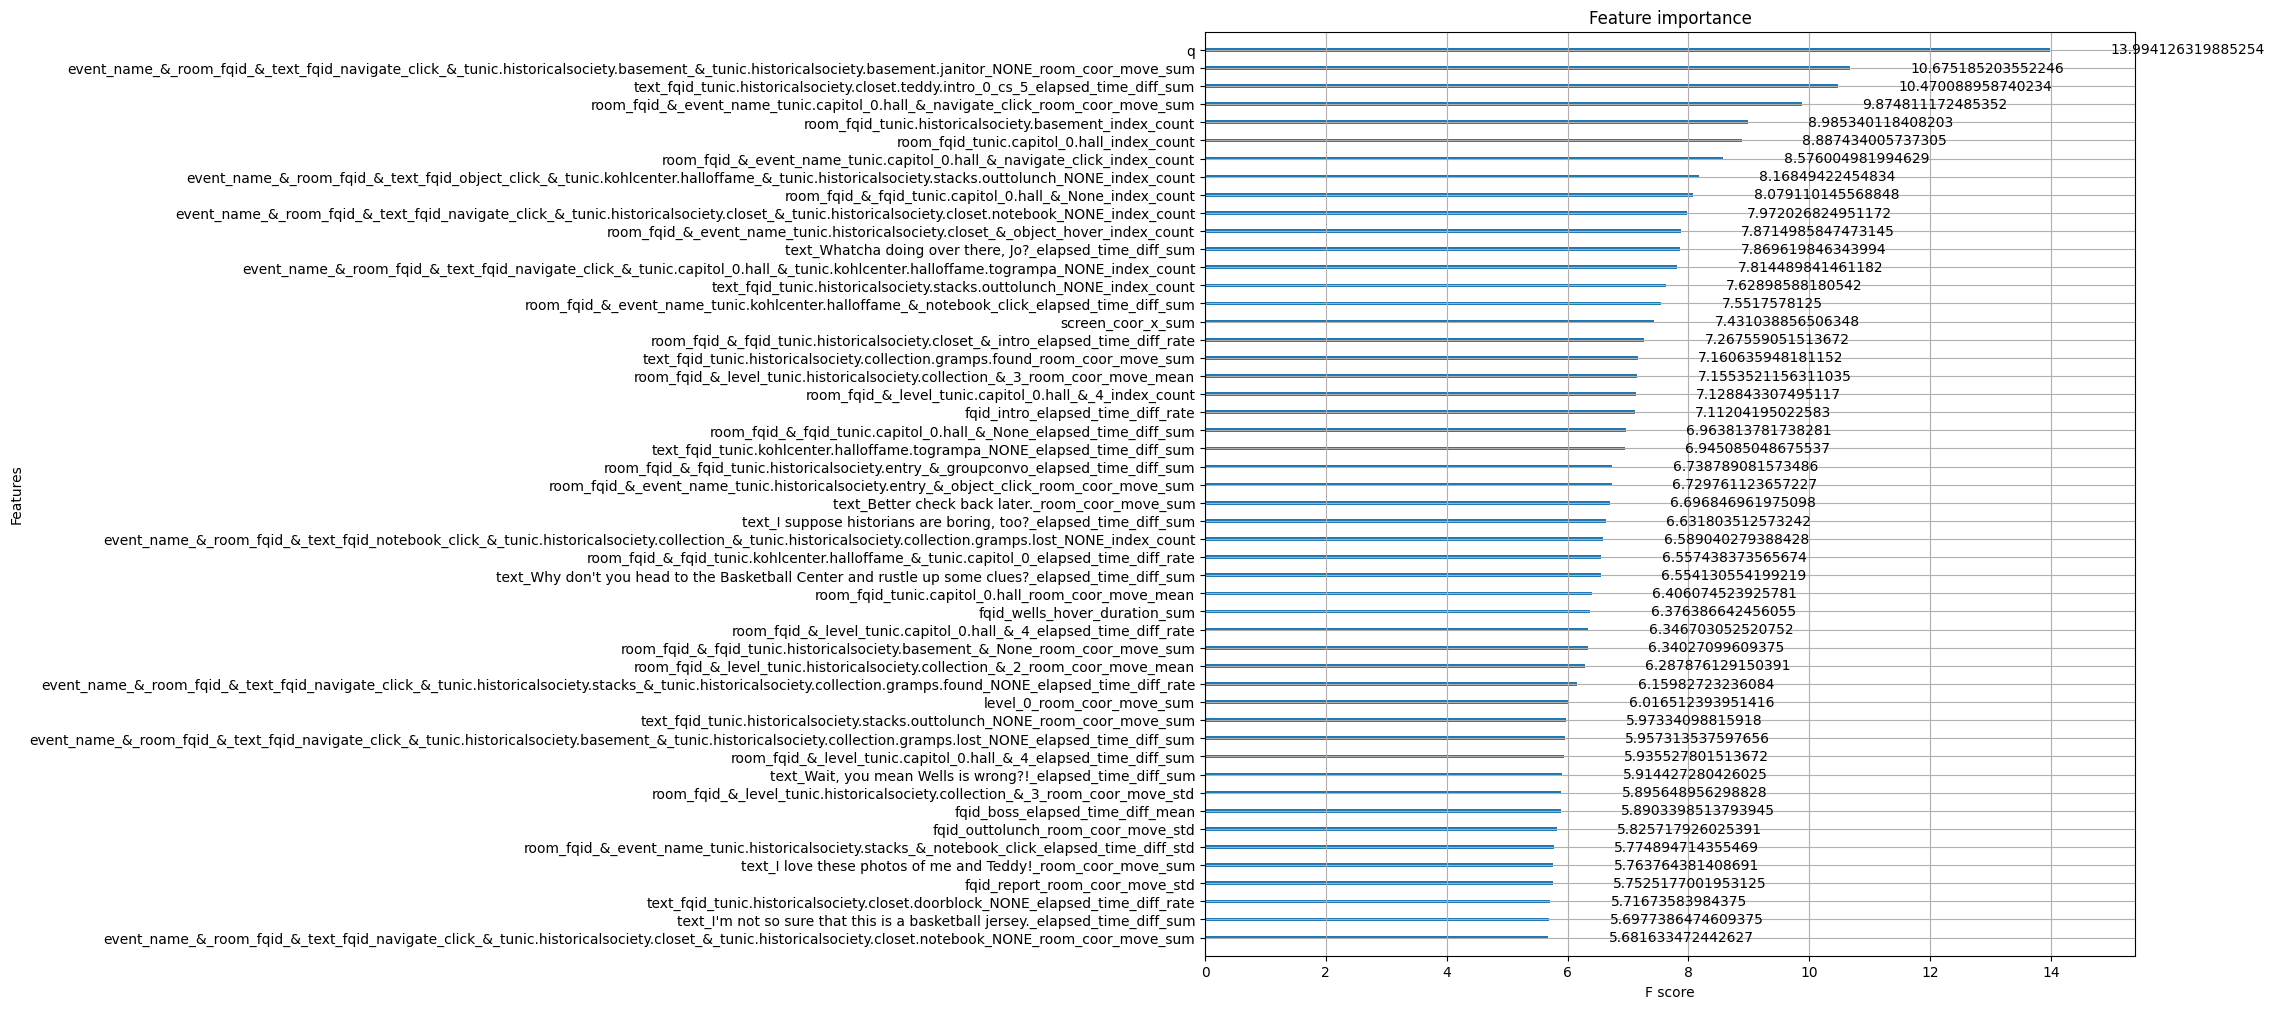

In [15]:
level_group = 0
fold = 0
vis_feat_imp(models_all[level_group][fold], 50)

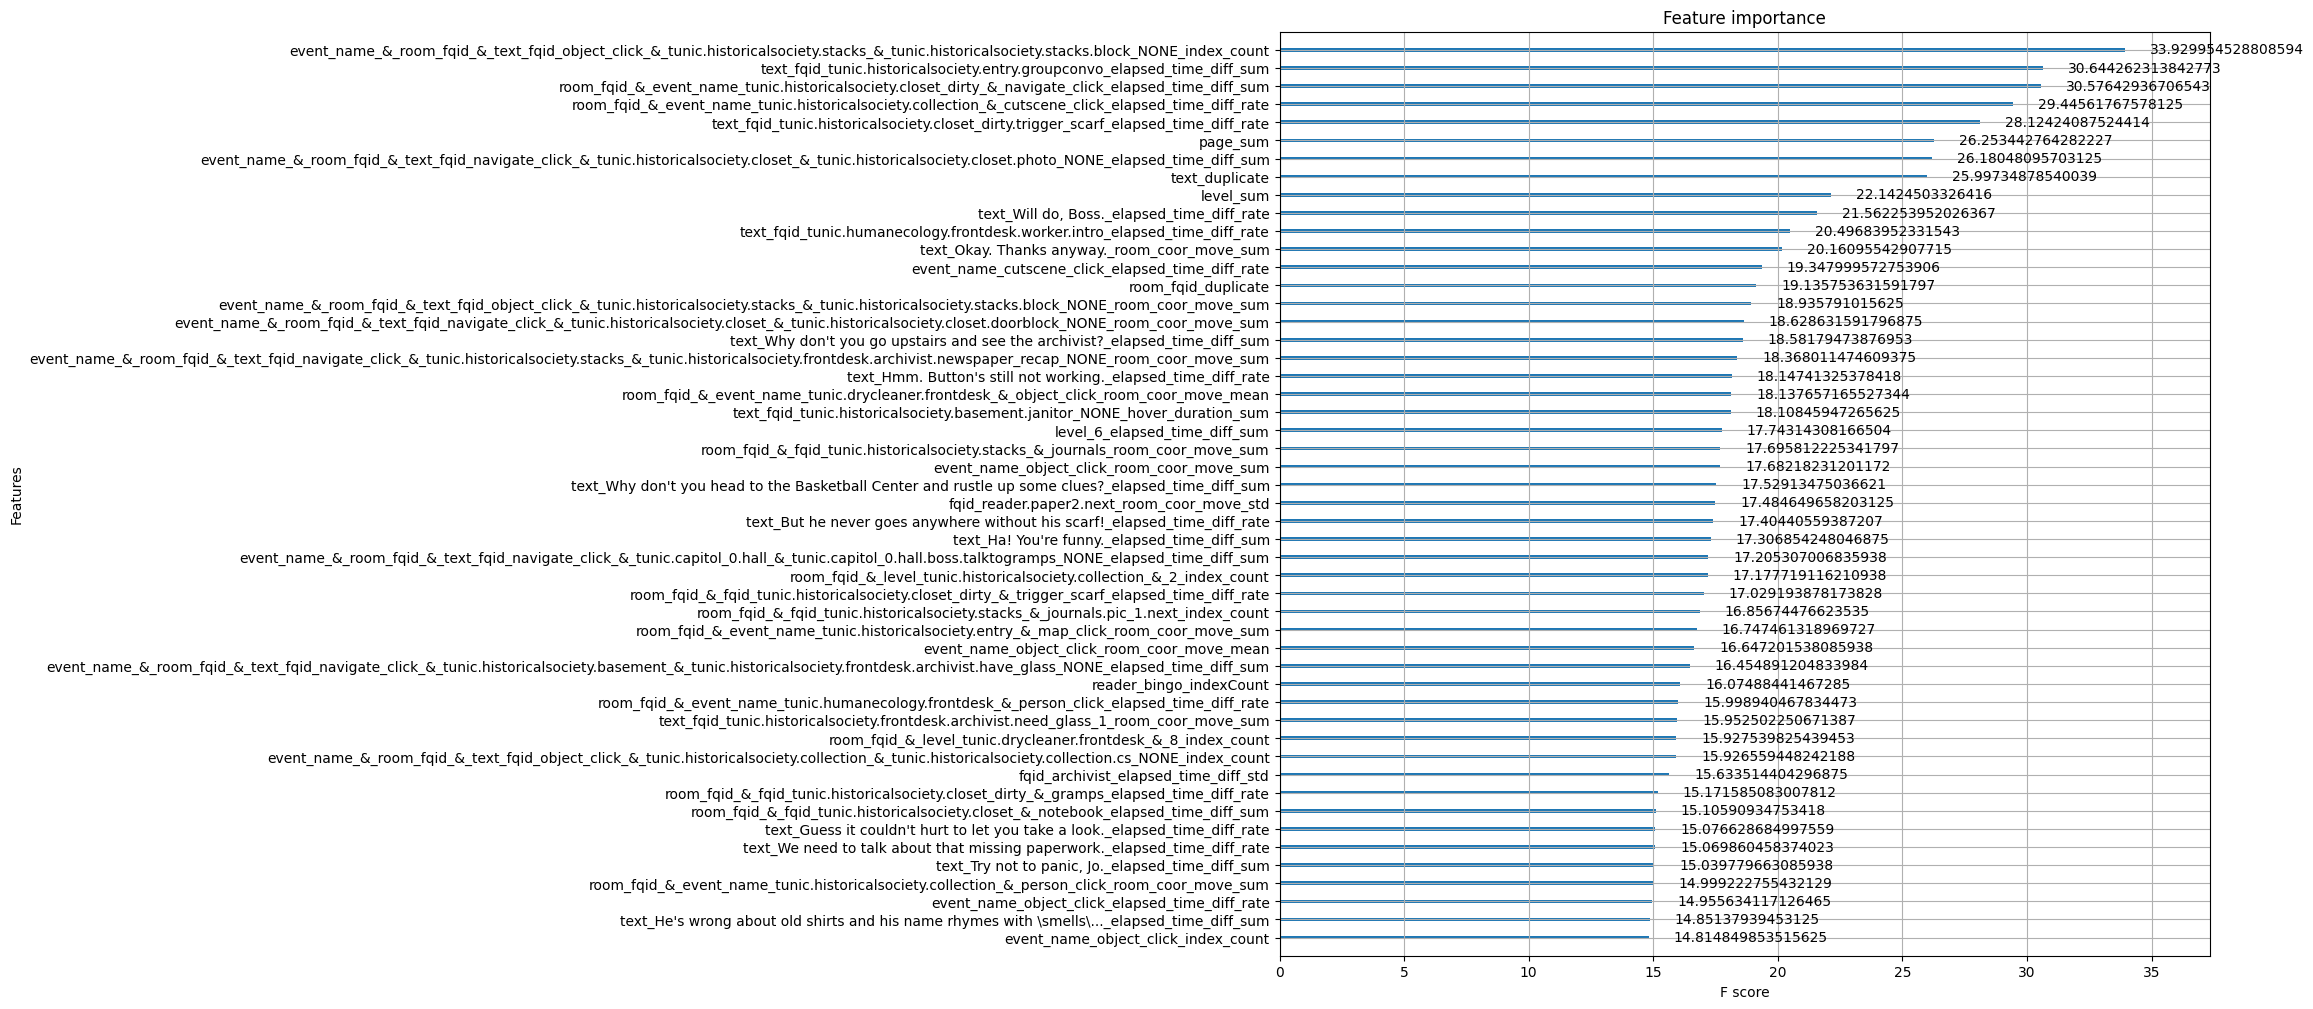

In [16]:
level_group = 1
fold = 0
vis_feat_imp(models_all[level_group][fold], 50)

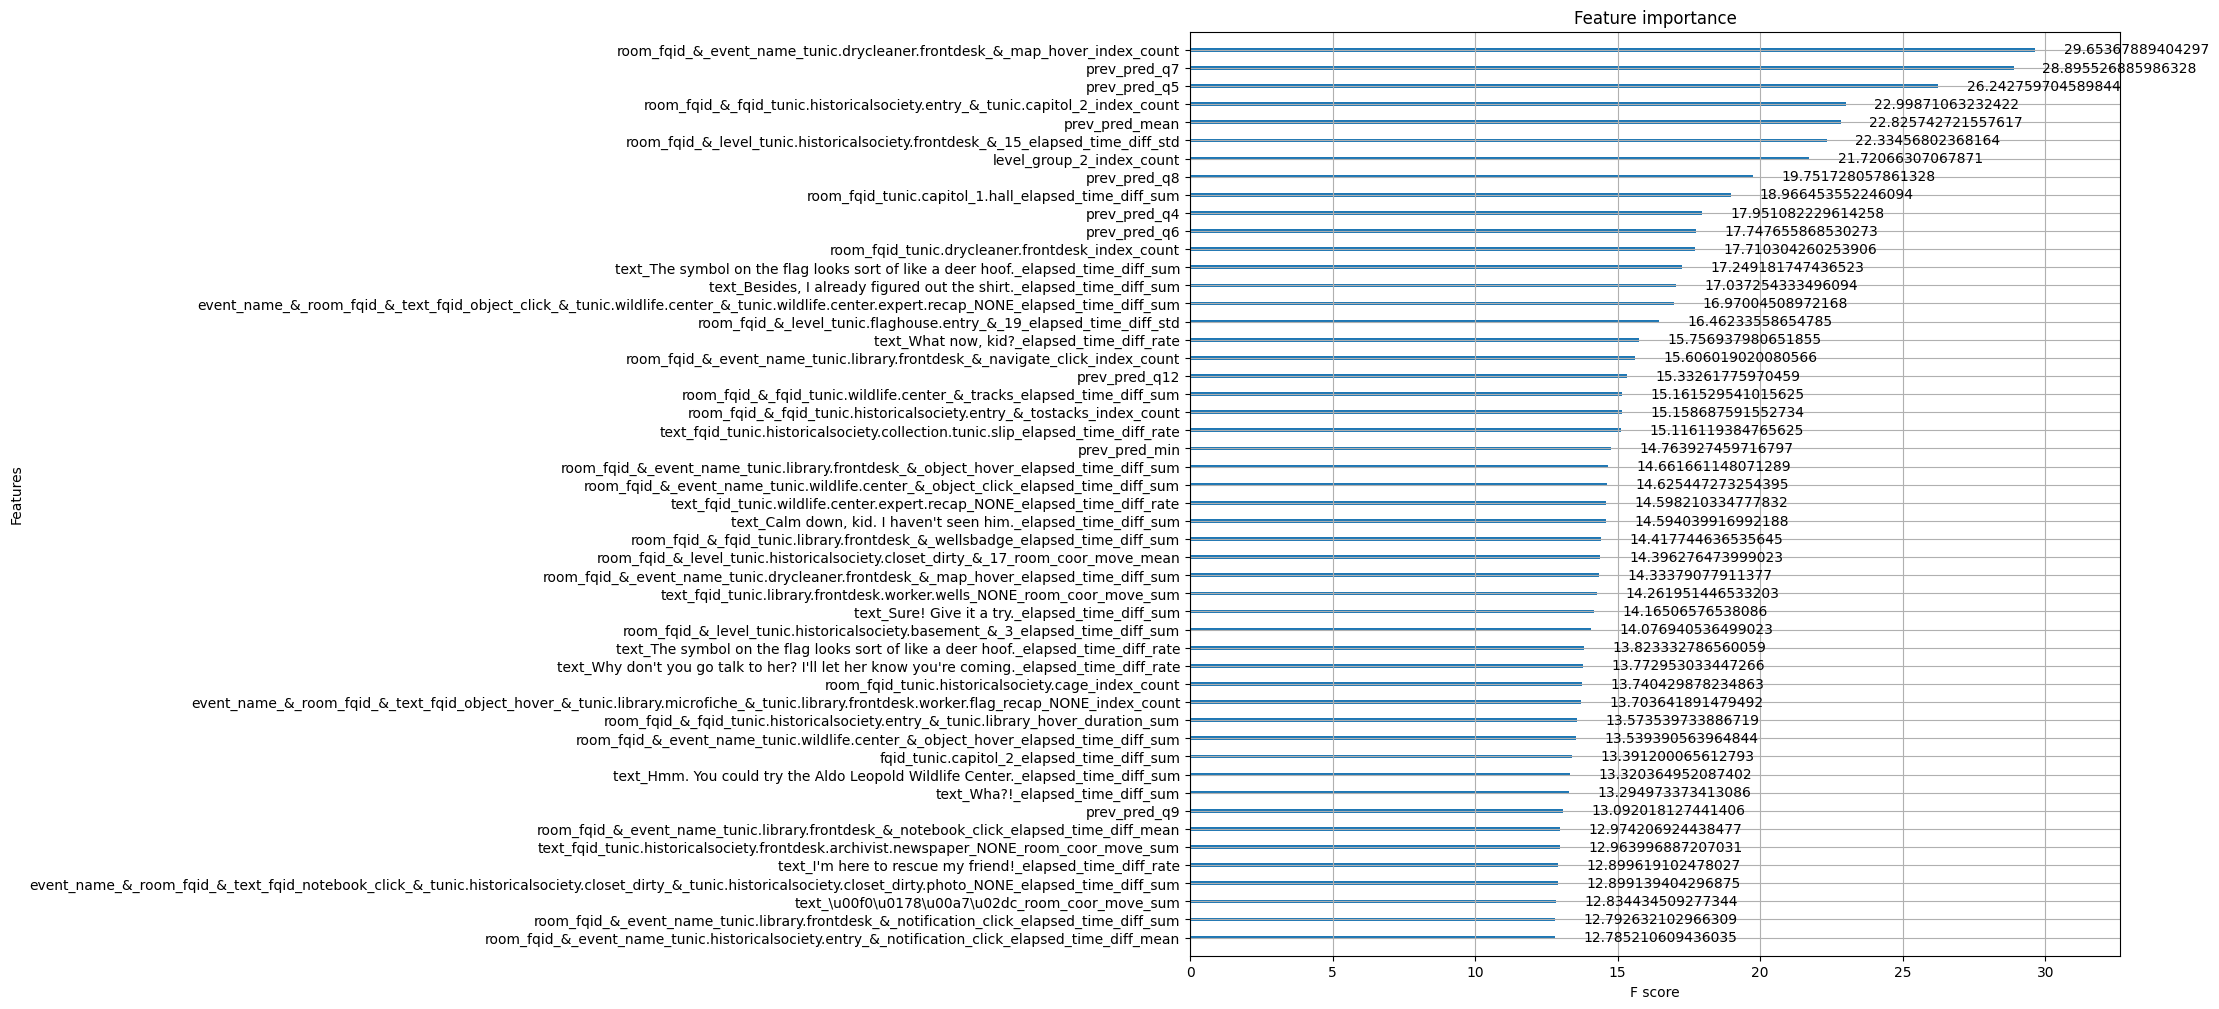

In [17]:
level_group = 2
fold = 0
vis_feat_imp(models_all[level_group][fold], 50)

### Feature Selection

In [40]:
use_feat_nums = [1000, 2000, 3000] # 1000, 1000, 1000
selected_feat_dict = select_feature(CFG.output_path, CFG.model_type, use_feat_nums=use_feat_nums)
[len(feat) for _, feat_list in selected_feat_dict.items() for feat in feat_list]

[1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000]

### Re Train

In [48]:
oof_df, models_all = all_level_group_train(
    CFG,
    all_df,
    train_labels,
    use_feat_dict=selected_feat_dict,
    use_prev_pred=True,
    save_model = True,
    train_type = 'with_fs'
)

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-logloss:0.68584	valid-logloss:0.68674
[100]	train-logloss:0.34684	valid-logloss:0.39423
[200]	train-logloss:0.22118	valid-logloss:0.31227
[300]	train-logloss:0.15940	valid-logloss:0.28020
[400]	train-logloss:0.12041	valid-logloss:0.26860
[500]	train-logloss:0.09648	valid-logloss:0.26761
[506]	train-logloss:0.09461	valid-logloss:0.26710
[0]	train-logloss:0.68576	valid-logloss:0.68725
[100]	train-logloss:0.33823	valid-logloss:0.42582
[200]	train-logloss:0.21135	valid-logloss:0.35922
[300]	train-logloss:0.15007	valid-logloss:0.34609
[394]	train-logloss:0.11426	valid-logloss:0.34657
[0]	train-logloss:0.68593	valid-logloss:0.68692
[100]	train-logloss:0.34247	valid-logloss:0.40057
[200]	train-logloss:0.21497	valid-logloss:0.31427
[300]	train-logloss:0.15304	valid-logloss:0.28567
[400]	train-logloss:0.11531	valid-logloss:0.27066
[463]	train-logloss:0.09963	valid-logloss:0.27062
[0]	train-logloss:0.68575	valid-logloss:0.68663
[100]	train-logloss:0.33434	valid-logloss:0.41084
[200]	tr

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-logloss:0.69047	valid-logloss:0.69125
[100]	train-logloss:0.56689	valid-logloss:0.60338
[200]	train-logloss:0.51100	valid-logloss:0.57110
[300]	train-logloss:0.47861	valid-logloss:0.55805
[400]	train-logloss:0.45370	valid-logloss:0.55058
[500]	train-logloss:0.43675	valid-logloss:0.54808
[600]	train-logloss:0.42334	valid-logloss:0.54687
[637]	train-logloss:0.41840	valid-logloss:0.54675
[0]	train-logloss:0.69031	valid-logloss:0.69123
[100]	train-logloss:0.55920	valid-logloss:0.62247
[200]	train-logloss:0.50203	valid-logloss:0.60245
[300]	train-logloss:0.47040	valid-logloss:0.59425
[400]	train-logloss:0.44671	valid-logloss:0.59063
[500]	train-logloss:0.42913	valid-logloss:0.58898
[572]	train-logloss:0.41909	valid-logloss:0.58869
[0]	train-logloss:0.69070	valid-logloss:0.69070
[100]	train-logloss:0.57092	valid-logloss:0.59365
[200]	train-logloss:0.51953	valid-logloss:0.55561
[300]	train-logloss:0.48933	valid-logloss:0.53563
[400]	train-logloss:0.46682	valid-logloss:0.52457
[500]	

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-logloss:0.68951	valid-logloss:0.69025
[100]	train-logloss:0.52975	valid-logloss:0.58174
[200]	train-logloss:0.46041	valid-logloss:0.54833
[300]	train-logloss:0.42184	valid-logloss:0.53267
[400]	train-logloss:0.39282	valid-logloss:0.52794
[457]	train-logloss:0.38079	valid-logloss:0.52809
[0]	train-logloss:0.68997	valid-logloss:0.69122
[100]	train-logloss:0.53505	valid-logloss:0.60372
[200]	train-logloss:0.47047	valid-logloss:0.57629
[300]	train-logloss:0.43367	valid-logloss:0.56362
[400]	train-logloss:0.40711	valid-logloss:0.55613
[500]	train-logloss:0.38968	valid-logloss:0.55356
[594]	train-logloss:0.37875	valid-logloss:0.55433
[0]	train-logloss:0.69002	valid-logloss:0.69092
[100]	train-logloss:0.52966	valid-logloss:0.58962
[200]	train-logloss:0.46047	valid-logloss:0.56066
[300]	train-logloss:0.42107	valid-logloss:0.55012
[400]	train-logloss:0.39417	valid-logloss:0.54559
[500]	train-logloss:0.37611	valid-logloss:0.54488
[528]	train-logloss:0.37198	valid-logloss:0.54608
[0]	tr

### Metric

In [49]:
results = get_score_and_th(
    oof_df,
    all_opt_flag=True,
    each_opt_flag=True,
    logger=logger
)

All Opt -->> best score=0.6843, threshold=0.6300
Each Opt -->> best score=0.6986, threshold=[0.82326005 0.38201921 0.23612118 0.37155683 0.6826842  0.61807545
 0.61808772 0.76926957 0.59607583 0.67320391 0.62345182 0.51425923
 0.67902194 0.61441307 0.79336157 0.35859913 0.50451904 0.6012809 ]


### Feature Importance

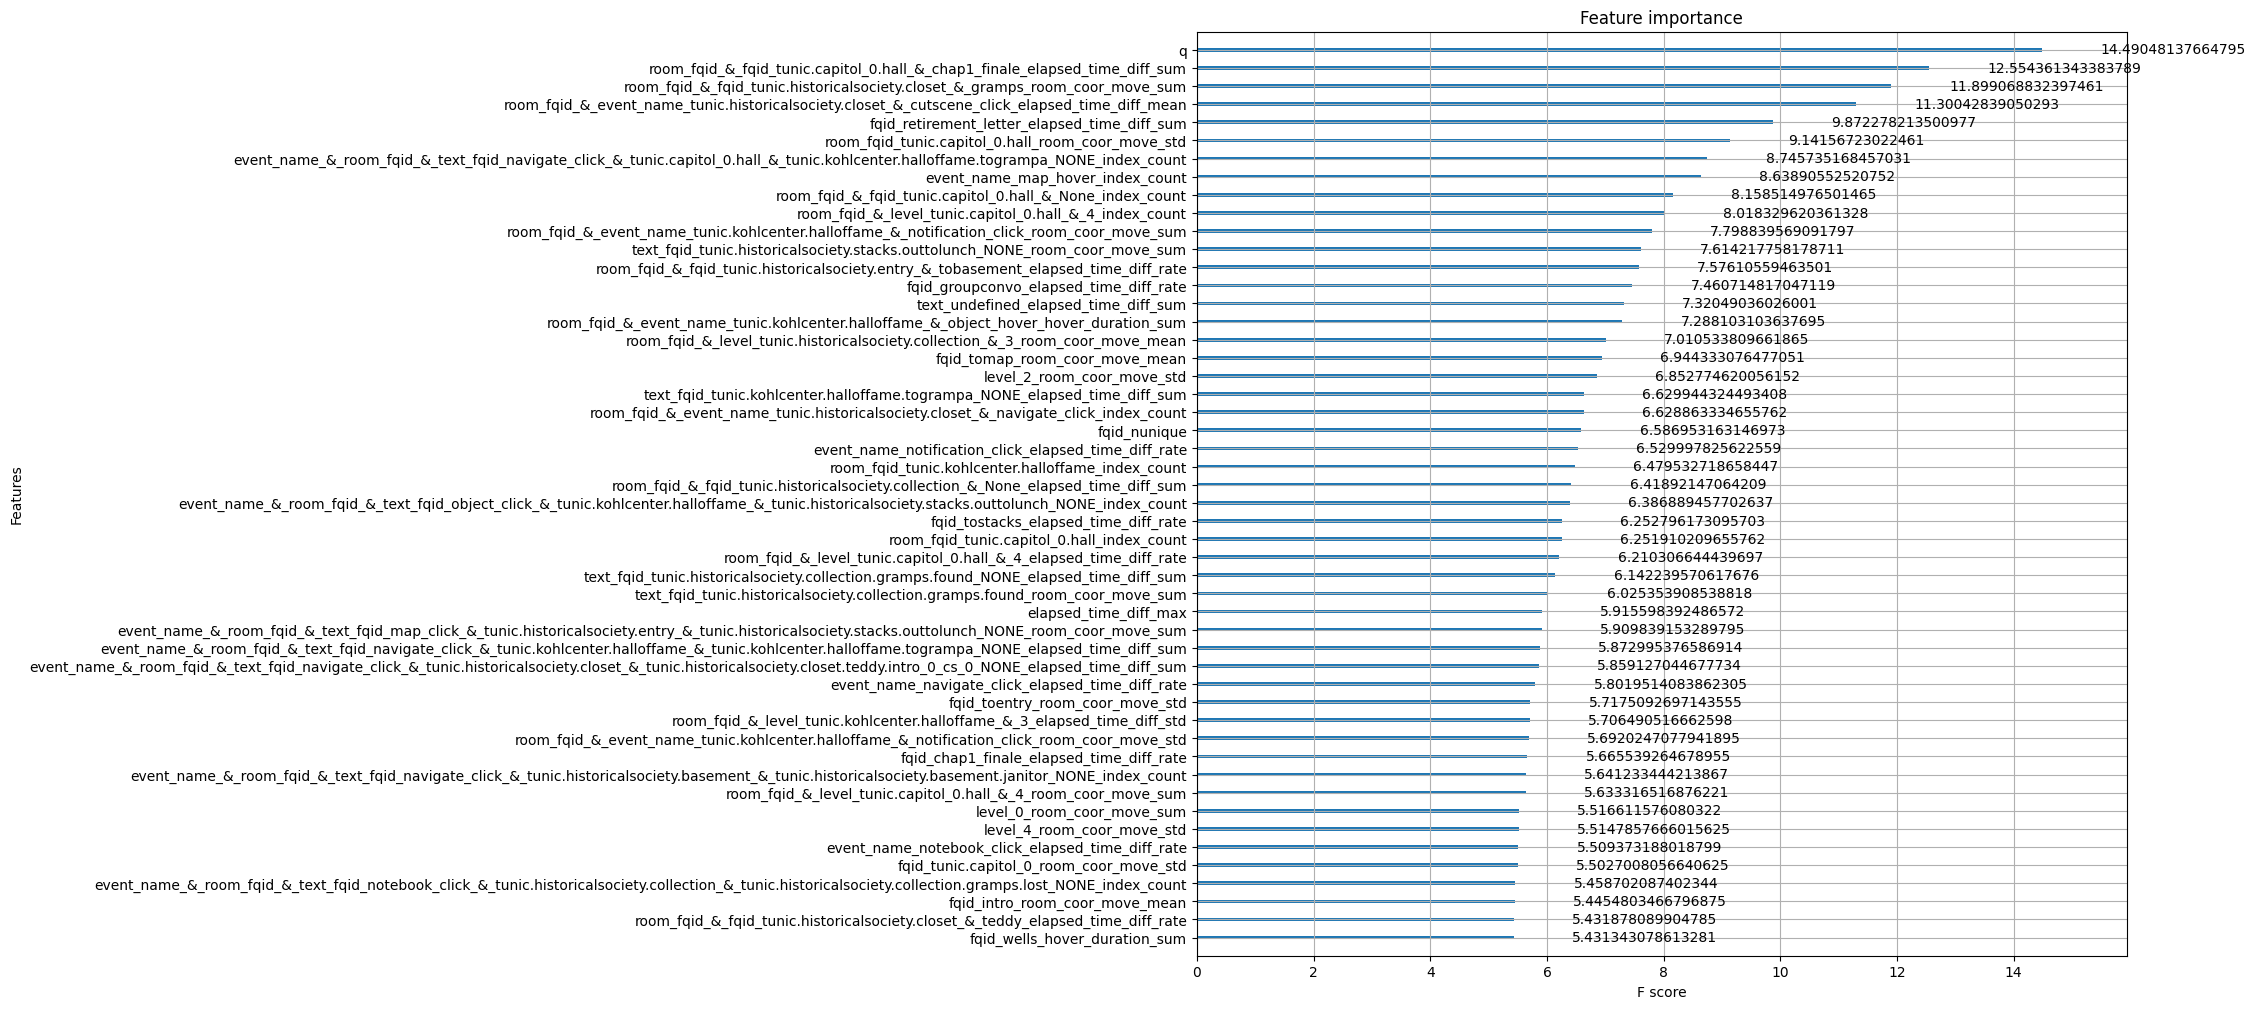

In [50]:
level_group = 0
fold = 0
vis_feat_imp(models_all[level_group][fold], 50)

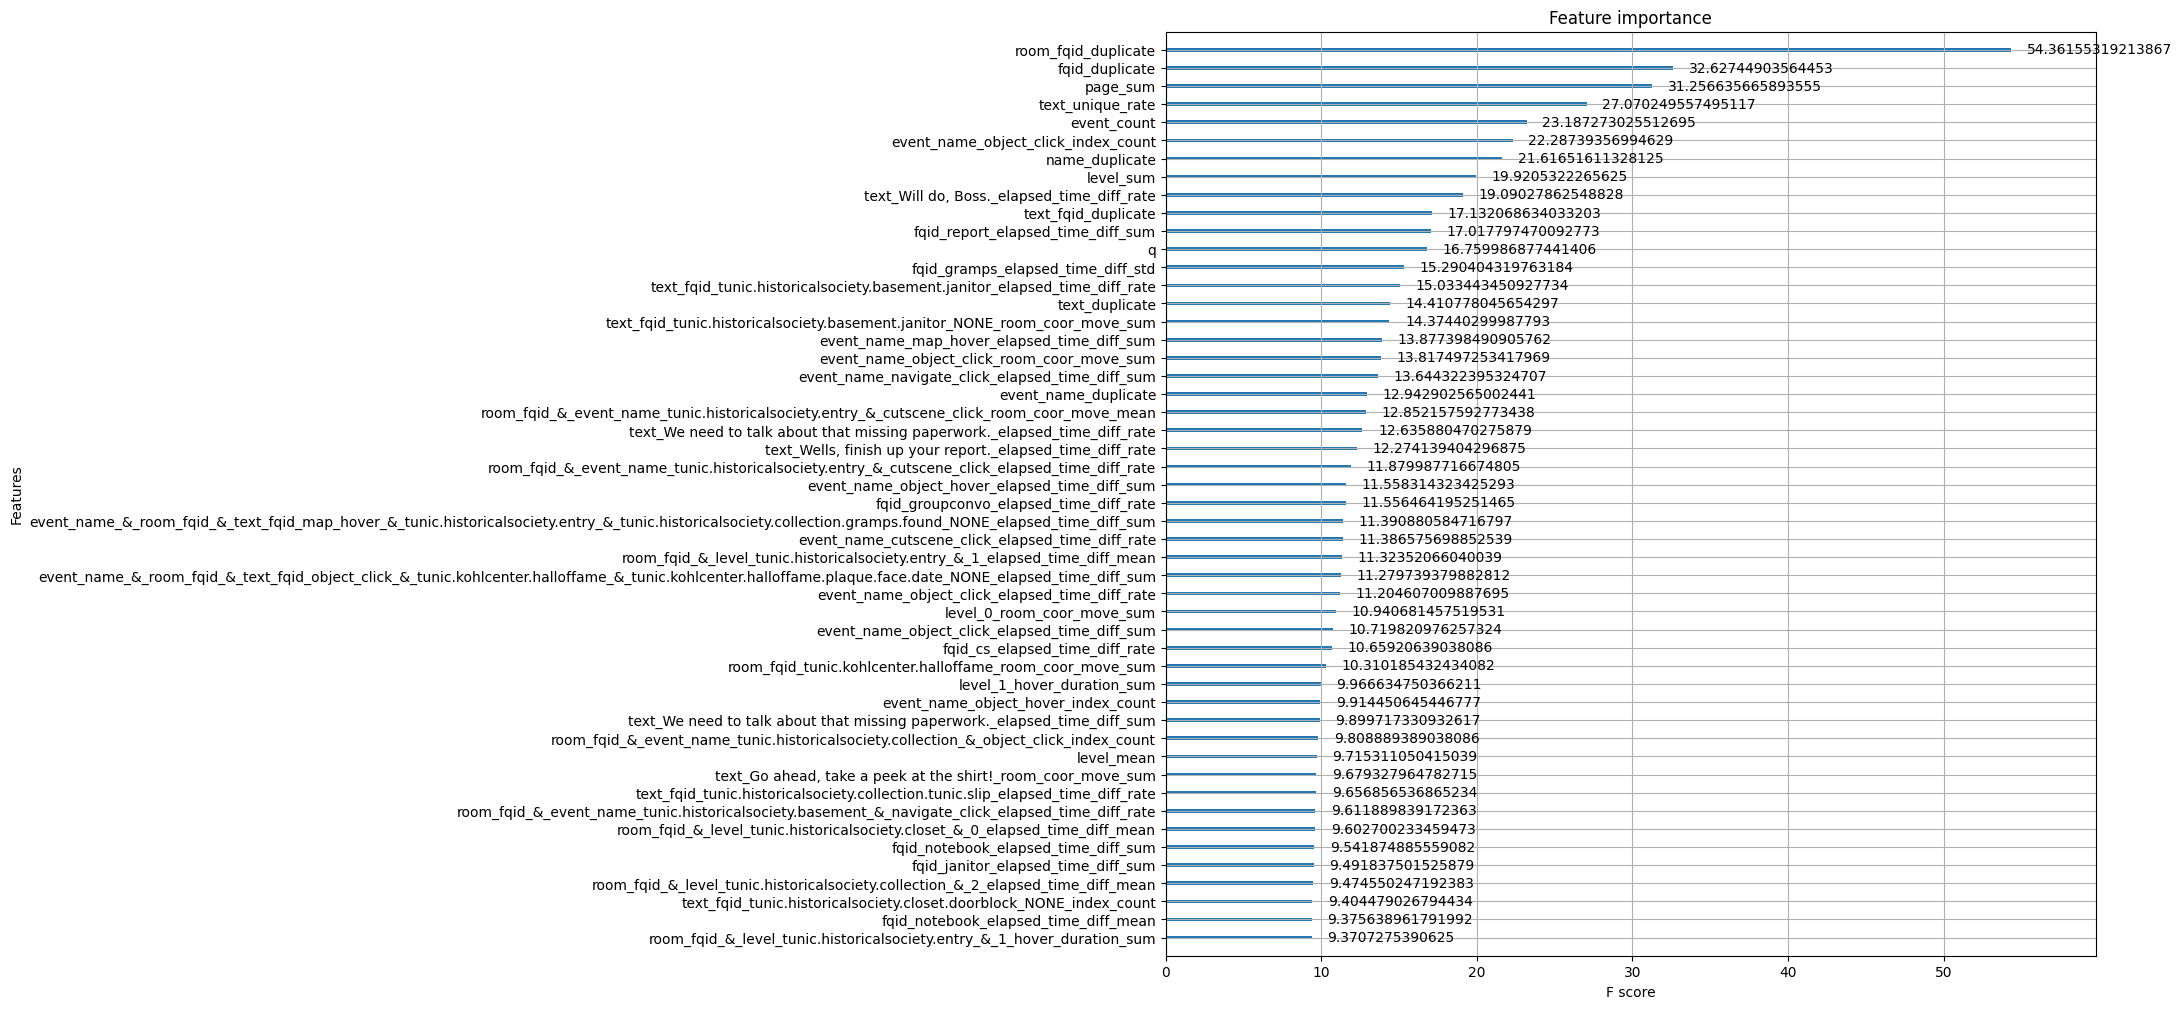

In [51]:
level_group = 1
fold = 0
vis_feat_imp(models_all[level_group][fold], 50)

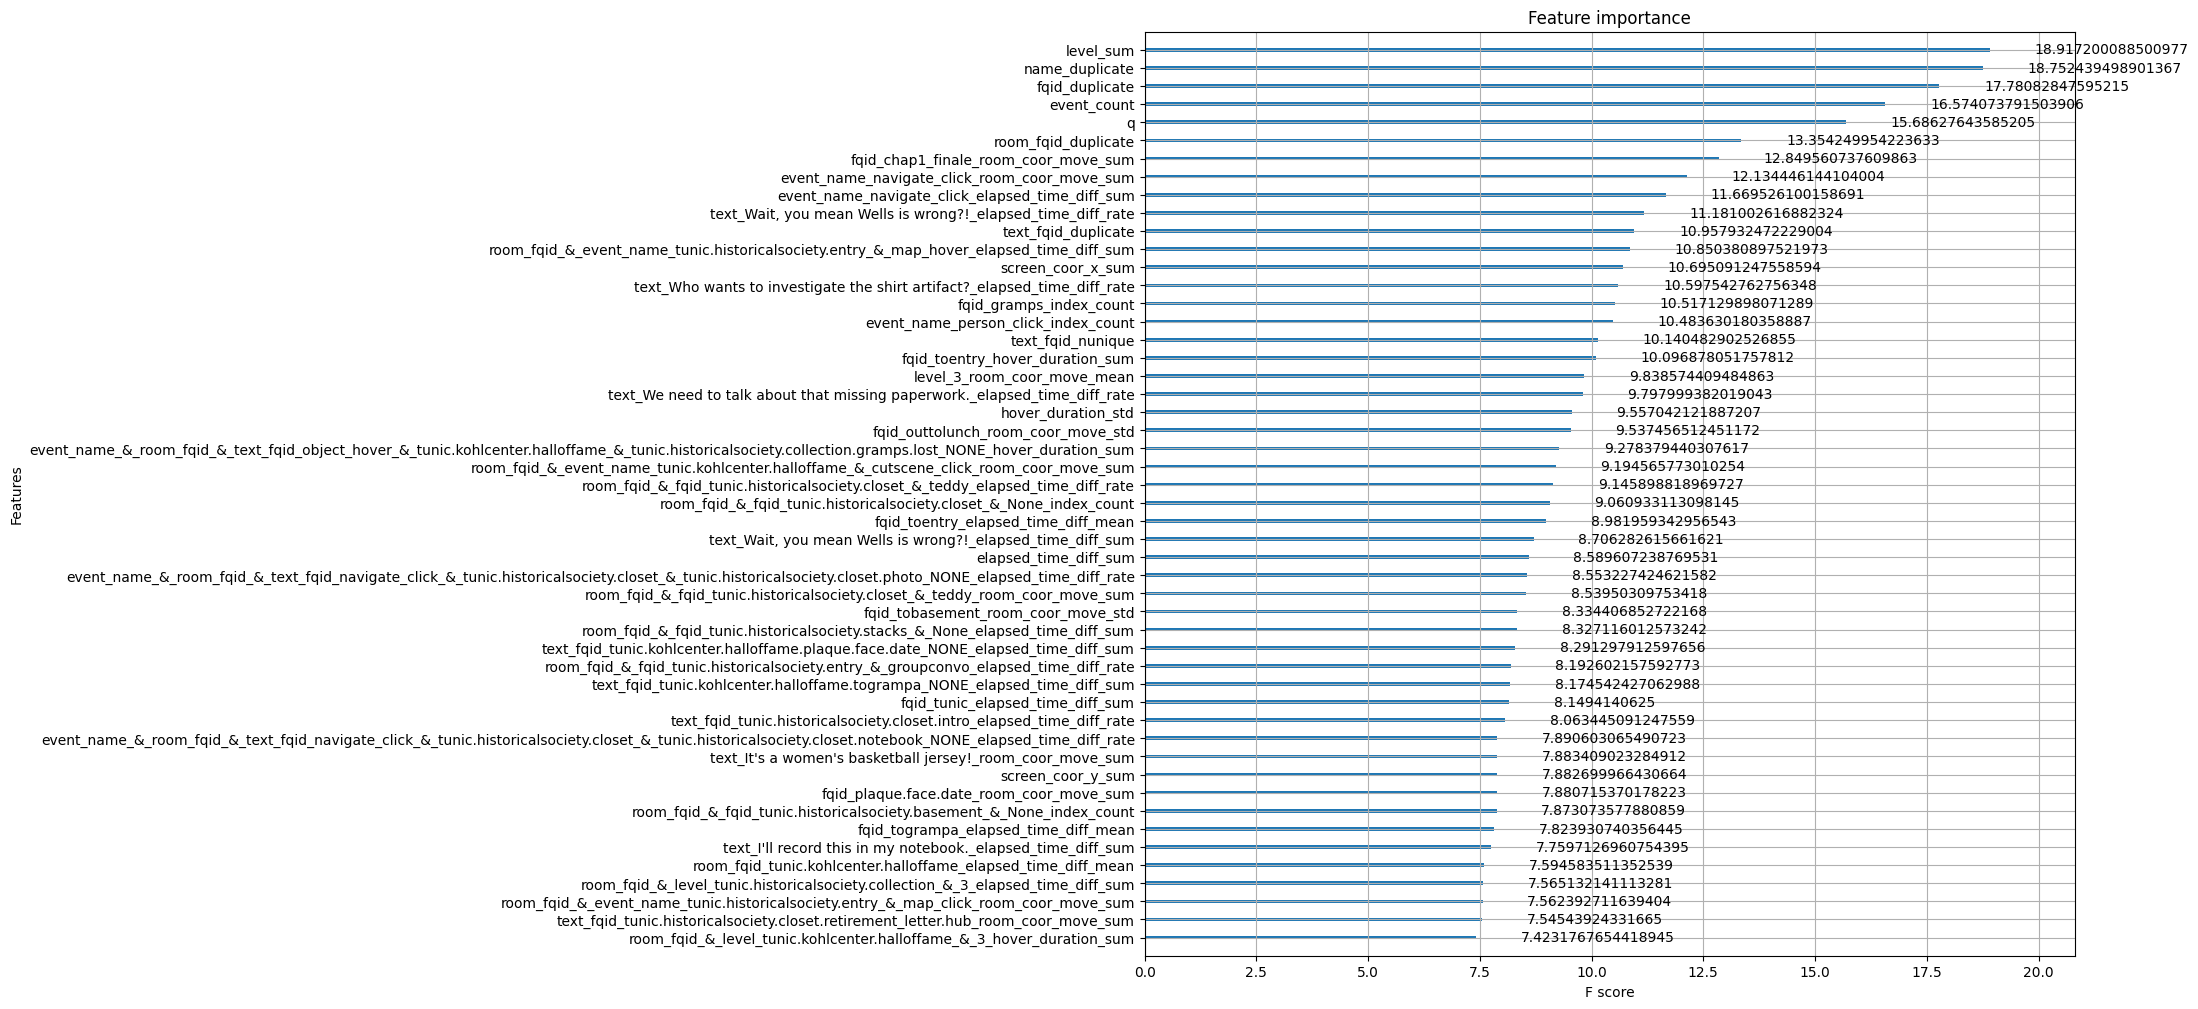

In [52]:
level_group = 2
fold = 0
vis_feat_imp(models_all[level_group][fold], 50)